# Simple CNN with **PyTorch** — MNIST Example

This notebook builds a minimal **Convolutional Neural Network (CNN)** in **PyTorch** and trains it on the **MNIST** handwritten digits dataset.

**What you'll learn**
- Loading MNIST with `torchvision.datasets`
- Preparing `DataLoader`s
- Defining a small CNN in `torch.nn`
- Writing a training + evaluation loop
- Plotting training curves and visualizing predictions

Every cell is commented line-by-line to explain what it does.


In [ ]:
!python -m pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [ ]:
!pip install torch>=2.2.0

In [ ]:
!pip install torchvision>=0.17.0

In [ ]:
!pip install numpy>=1.23.0

In [ ]:
!pip install matplotlib>=3.7.0

In [ ]:
# --- Imports ---
import torch                       # Core PyTorch library (tensors, autograd)
import torch.nn as nn              # Neural network building blocks
import torch.optim as optim        # Optimizers (SGD, Adam, etc.)
from torch.utils.data import DataLoader  # Efficient mini-batching
from torchvision import datasets, transforms  # Datasets and common transforms

import numpy as np                 # Numerical utilities
import matplotlib.pyplot as plt    # Plotting curves and images

# Check PyTorch version and CUDA availability
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available for speed
print('Using device:', device)

# For (more) reproducible results across runs
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


PyTorch version: 2.8.0+cu126
Using device: cpu


In [ ]:
# --- Load and preprocess MNIST ---
# Define a composition of transforms to apply to each image
# 1) transforms.ToTensor(): converts PIL image [0,255] -> float tensor [0,1] (C,H,W)
# 2) transforms.Normalize: standardize with MNIST mean and std for better training
transform = transforms.Compose([
    transforms.ToTensor(),                        # Convert to tensor (1, 28, 28)
    transforms.Normalize((0.1307,), (0.3081,))    # Standard MNIST mean/std
])



# Download and create the training and test datasets (will cache locally)
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Wrap datasets in DataLoader to handle batching, shuffling, and parallel loading
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print('Train batches:', len(train_loader), '| Test batches:', len(test_loader))


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 369kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.29MB/s]


Train batches: 469 | Test batches: 20


In [ ]:
# --- Define a simple CNN ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()  # Initialize base nn.Module
        # Convolutional feature extractor
        self.conv_block = nn.Sequential(
            # Conv layer: in_channels=1 (grayscale), out_channels=32 filters, kernel size 3x3
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),           # Non-linearity
            nn.MaxPool2d(kernel_size=2),     # Downsample: 28x28 -> 14x14

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)      # Downsample: 14x14 -> 7x7
        )
        # Classifier (fully-connected layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),                    # Flatten 64*7*7 feature maps to a 1D vector
            nn.Linear(64 * 7 * 7, 128),      # Dense layer with 128 units
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)               # Output logits for 10 classes (digits 0-9)
        )

    def forward(self, x):
        x = self.conv_block(x)               # Apply conv/pool layers
        x = self.classifier(x)               # Apply dense layers
        return x                             # Return raw logits (CrossEntropyLoss applies softmax internally)

# Instantiate the model and move it to the selected device (CPU/GPU)
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# --- Define loss function and optimizer ---
criterion = nn.CrossEntropyLoss()             # Suitable for multi-class classification with class indices
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam is a good default optimizer


In [ ]:
# --- Training and evaluation utilities ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()                 # Set model to training mode (enables dropout/batchnorm if present)
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:         # Iterate over mini-batches
        images = images.to(device, non_blocking=True)  # Move to device
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()             # Reset gradients from previous step
        outputs = model(images)           # Forward pass: compute logits
        loss = criterion(outputs, labels) # Compute loss

        loss.backward()                   # Backpropagate to compute gradients
        optimizer.step()                  # Update weights

        running_loss += loss.item() * images.size(0)   # Accumulate sum of batch losses
        preds = outputs.argmax(dim=1)    # Predicted class = index of max logit
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()                 # Evaluation mode: disables dropout/batchnorm updates
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
# --- Run training for a few epochs ---
num_epochs = 5  # Increase to 10+ for higher accuracy

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(f'Epoch {epoch:02d}/{num_epochs} | '
          f'Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | '
          f'Val Loss: {va_loss:.4f} Acc: {va_acc:.4f}')


Epoch 01/5 | Train Loss: 0.1729 Acc: 0.9470 | Val Loss: 0.0563 Acc: 0.9833
Epoch 02/5 | Train Loss: 0.0465 Acc: 0.9856 | Val Loss: 0.0416 Acc: 0.9863
Epoch 03/5 | Train Loss: 0.0331 Acc: 0.9902 | Val Loss: 0.0308 Acc: 0.9896
Epoch 04/5 | Train Loss: 0.0240 Acc: 0.9921 | Val Loss: 0.0380 Acc: 0.9878
Epoch 05/5 | Train Loss: 0.0180 Acc: 0.9940 | Val Loss: 0.0290 Acc: 0.9910


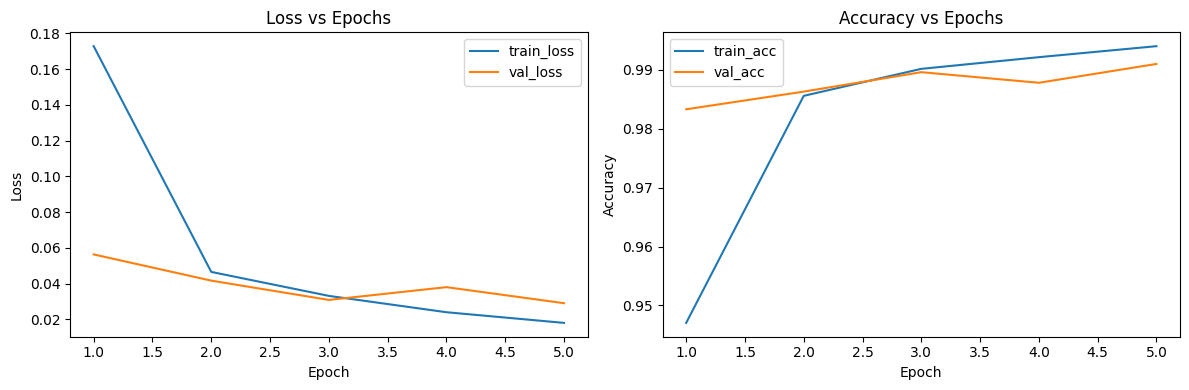

In [ ]:
# --- Plot training curves ---
# We use matplotlib to visualize how loss and accuracy evolve across epochs.
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='train_loss')
plt.plot(epochs, val_losses, label='val_loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='train_acc')
plt.plot(epochs, val_accs, label='val_acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


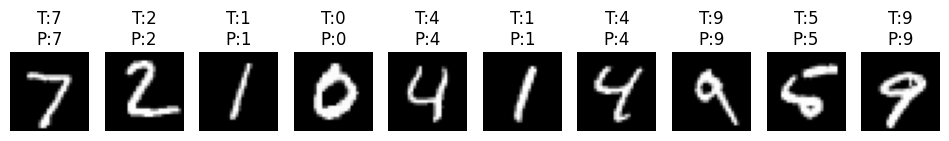

In [ ]:
# --- Visualize a few predictions ---
# We'll take a mini-batch from the test loader, run inference, and plot some results.
model.eval()
images, labels = next(iter(test_loader))              # Grab a batch (images: [B,1,28,28])
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    logits = model(images)                            # Forward pass
preds = logits.argmax(dim=1)                          # Convert logits to predicted class indices

# Move a few samples to CPU and plot
num_show = 10
plt.figure(figsize=(12, 3))
for i in range(num_show):
    img = images[i].detach().cpu().squeeze(0)         # [1,28,28] -> [28,28]
    plt.subplot(1, num_show, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'T:{labels[i].item()}\nP:{preds[i].item()}')
    plt.axis('off')
plt.show()


```markdown
# Simple CNN with PyTorch — MNIST Example

This notebook demonstrates how to build, train, and evaluate a basic Convolutional Neural Network (CNN) using PyTorch on the well-known MNIST dataset of handwritten digits.

## Table of Contents

1.  **Setup**: Installation of necessary libraries (PyTorch, torchvision, numpy, matplotlib).
2.  **Imports and Device Configuration**: Importing core libraries and setting up the computational device (CPU/GPU).
3.  **Data Loading and Preprocessing**: Loading the MNIST dataset using `torchvision.datasets`, applying transformations (`ToTensor`, `Normalize`), and preparing `DataLoader`s for efficient batching.
4.  **Model Definition**: Defining a simple CNN architecture using `torch.nn.Module`, consisting of convolutional layers, ReLU activations, Max Pooling, flattening, and fully-connected layers for classification.
5.  **Loss Function and Optimizer**: Setting up `nn.CrossEntropyLoss` and the `Adam` optimizer.
6.  **Training and Evaluation Utilities**: Implementing `train_one_epoch` and `evaluate` functions to manage the training and validation loops.
7.  **Training Execution**: Running the training process for a specified number of epochs and logging performance metrics.
8.  **Plotting Training Curves**: Visualizing the training and validation loss and accuracy over epochs using `matplotlib`.
9.  **Visualizing Predictions**: Displaying sample images from the test set along with their true labels and the model's predictions to qualitatively assess performance.

## What You'll Learn

*   How to load standard datasets like MNIST using `torchvision.datasets`.
*   Effective use of `torch.utils.data.DataLoader` for batching, shuffling, and parallel data loading.
*   Defining custom neural network architectures with `torch.nn.Module` and its layers (`Conv2d`, `ReLU`, `MaxPool2d`, `Linear`, `Flatten`).
*   Implementing a full training and evaluation loop in PyTorch.
*   Monitoring model performance through loss and accuracy plots.
*   Visualizing model predictions to understand its behavior.

## How to Run

1.  **Open in Google Colab**: Click the "Open in Colab" badge (if available) or upload the `.ipynb` file to your Google Drive and open it with Colaboratory.
2.  **Run All Cells**: Execute all cells in sequential order. The notebook is designed to be run from top to bottom.
3.  **GPU Acceleration (Optional)**: If you have access to a GPU runtime (Runtime > Change runtime type > GPU), it is recommended for faster training.

Enjoy learning about CNNs with PyTorch!
```